# RFM Analysis Workbook

This workbook presents an analysis of customer segmentation using RFM (Recency, Frequency, Monetary) analysis. The goal is to cluster customers based on their purchasing behavior to identify different segments and tailor marketing strategies accordingly. The analysis includes exploring the optimal number of clusters using the elbow method and Calinski curve, followed by detailed interpretation of the cluster characteristics.


#### Importing the basic libraries and the data

In [2]:
import numpy as np 
import pandas as pd 
import time, warnings
import datetime as dt
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

warnings.filterwarnings("ignore")

In [3]:
superstore_df = pd.read_excel('Sample - Superstore.xls')
superstore_df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2018-152156,2018-11-08,2018-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2018-152156,2018-11-08,2018-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2018-138688,2018-06-12,2018-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2017-108966,2017-10-11,2017-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2017-108966,2017-10-11,2017-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


### Doing Basic EDA

In [4]:
superstore_df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country/Region', 'City',
       'State', 'Postal Code', 'Region', 'Product ID', 'Category',
       'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount',
       'Profit'],
      dtype='object')

In [5]:
print(superstore_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          9994 non-null   int64         
 1   Order ID        9994 non-null   object        
 2   Order Date      9994 non-null   datetime64[ns]
 3   Ship Date       9994 non-null   datetime64[ns]
 4   Ship Mode       9994 non-null   object        
 5   Customer ID     9994 non-null   object        
 6   Customer Name   9994 non-null   object        
 7   Segment         9994 non-null   object        
 8   Country/Region  9994 non-null   object        
 9   City            9994 non-null   object        
 10  State           9994 non-null   object        
 11  Postal Code     9983 non-null   float64       
 12  Region          9994 non-null   object        
 13  Product ID      9994 non-null   object        
 14  Category        9994 non-null   object        
 15  Sub-

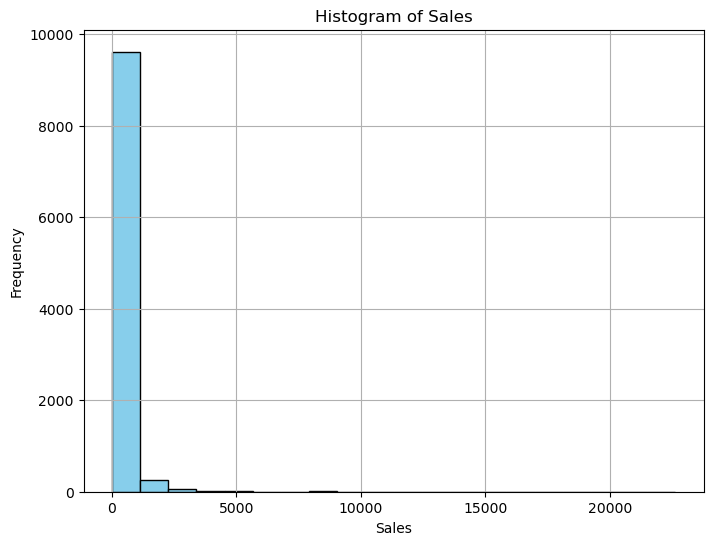

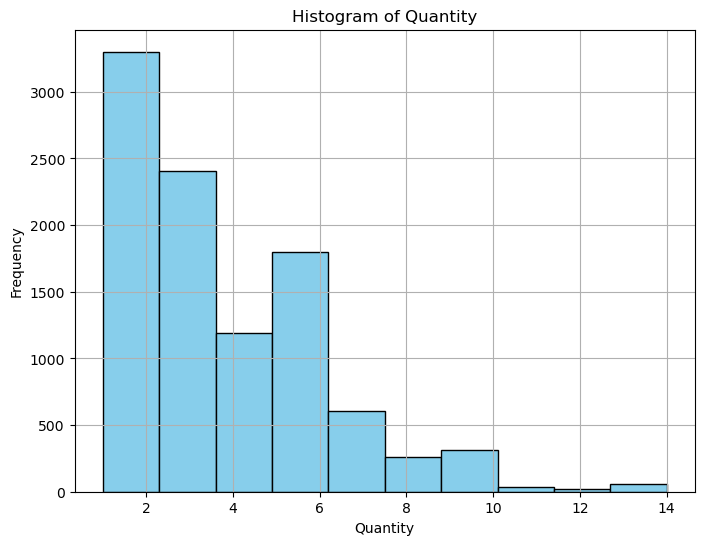

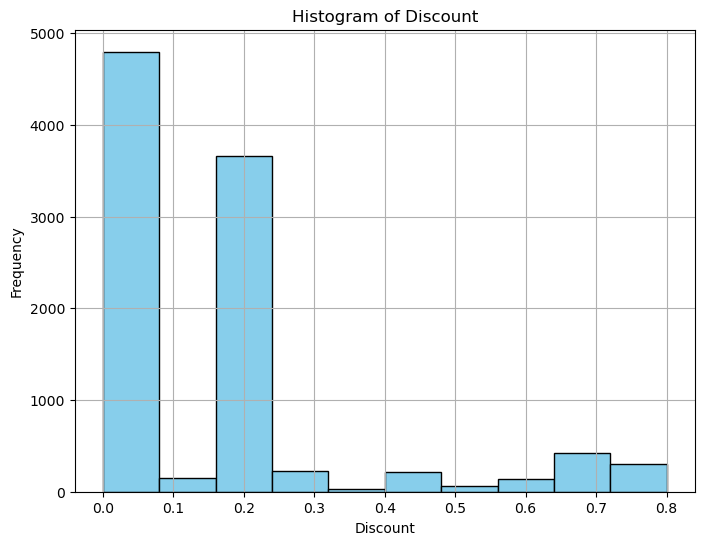

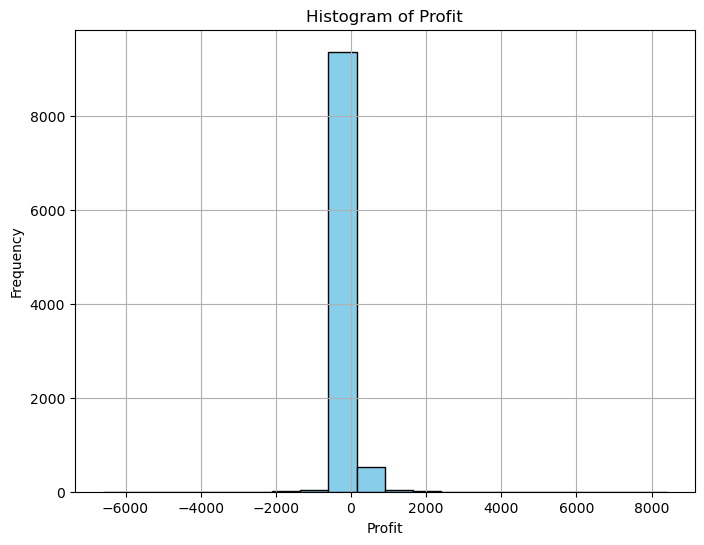

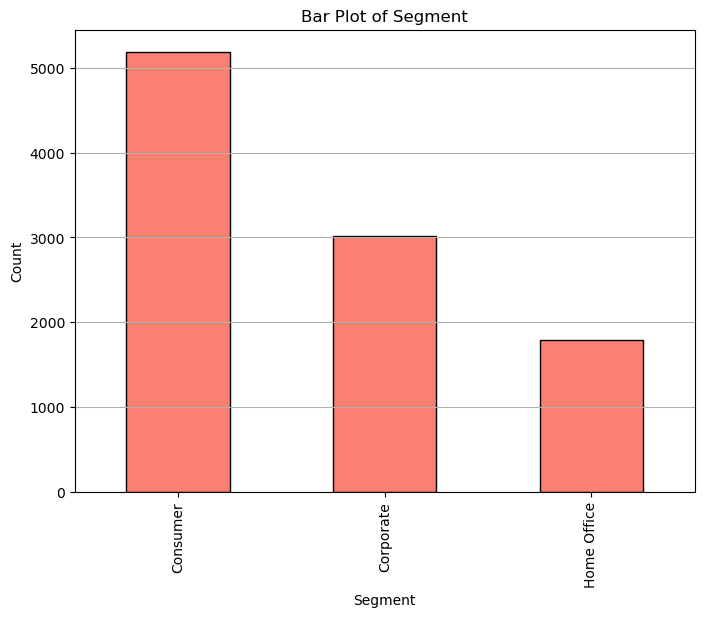

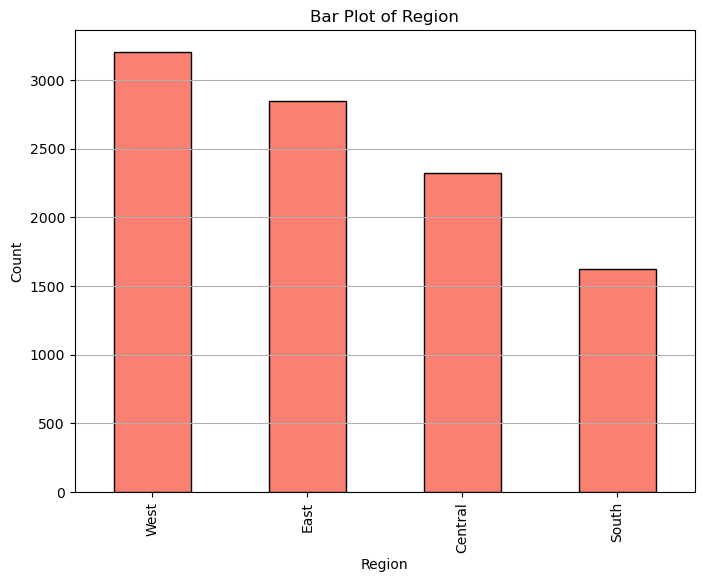

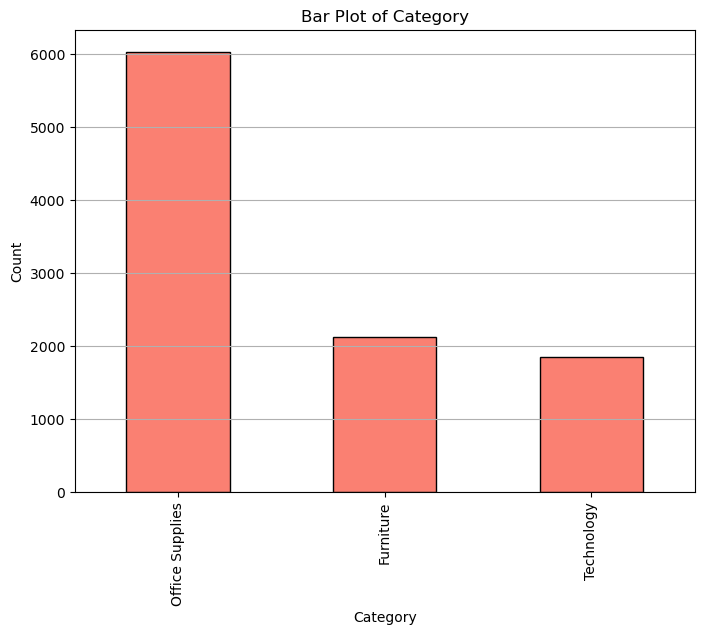

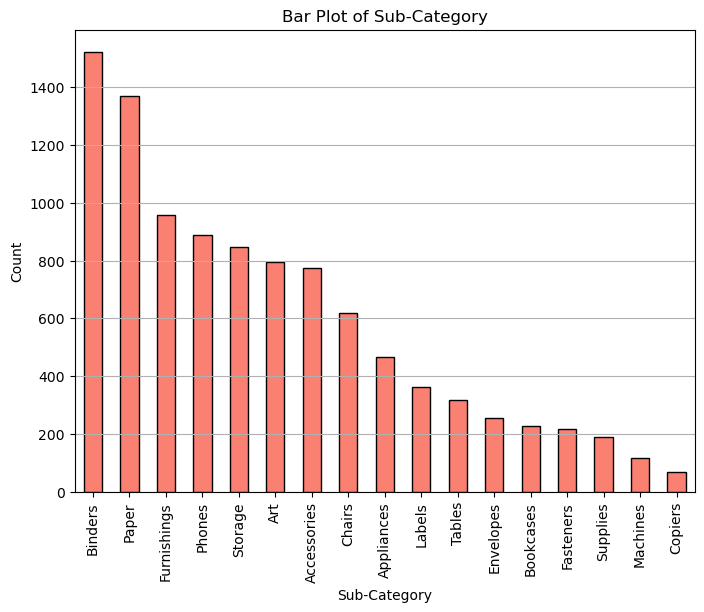

In [6]:
# Categorize columns into numerical and categorical
numerical_columns = ['Sales', 'Quantity', 'Discount', 'Profit']
categorical_columns = ['Segment', 'Region', 'Category', 'Sub-Category']

# Set the number of bins for each numerical column
num_bins = {
    'Sales': 20,
    'Quantity': 10,
    'Discount': 10,
    'Profit': 20
}

# Plot histograms for numerical columns with appropriate bins
for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(superstore_df[column], bins=num_bins.get(column, 'auto'), color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Plot bar plots for categorical columns
for column in categorical_columns:
    plt.figure(figsize=(8, 6))
    superstore_df[column].value_counts().plot(kind='bar', color='salmon', edgecolor='black')
    plt.title(f'Bar Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.grid(axis='y')
    plt.show()


Since the graphs of Sales and Profits provide little benefit in explaining what the data is about, we do a .describe() on them to gether better analysis.

In [7]:
# Describe the 'Sales' and 'Profit' columns
sales_profit_describe = superstore_df[['Sales', 'Profit']].describe()
print(sales_profit_describe)


              Sales       Profit
count   9994.000000  9994.000000
mean     229.858001    28.656896
std      623.245101   234.260108
min        0.444000 -6599.978000
25%       17.280000     1.728750
50%       54.490000     8.666500
75%      209.940000    29.364000
max    22638.480000  8399.976000


In [8]:
sales_concentration = superstore_df.groupby("State")["Row ID"].count().sort_values(ascending=False).to_frame()
sales_concentration.head(8)

,Row ID
State,
California,2001
New York,1128
Texas,985
Pennsylvania,587
Washington,506
Illinois,492
Ohio,469
Florida,383


### Making a coopy of the data for RFM analysis

In [9]:
sales = superstore_df.copy()
sales.shape

(9994, 21)

Removing any cancelled orders and any customers where their IDs are NA. These anomalies are removed to fix the data

In [10]:
sales = sales[sales['Quantity']>0]
sales.shape


(9994, 21)

The same shape as before so we can assume no canceled order

In [11]:
#remove rows where customerID are NA
sales.dropna(subset=['Customer ID'],how='all',inplace=True)
sales.shape

(9994, 21)

In [12]:
sales['Order Date'] = pd.to_datetime(sales['Order Date'], format='%m/%d/%Y')

sales['Order Date'].dt.year.value_counts()

Order Date
2019    3312
2018    2587
2017    2102
2016    1993
Name: count, dtype: int64

In [13]:
print("Summary..")
#exploring the unique values of each attribute
print("Number of transactions: ", sales['Order ID'].nunique())
print("Number of products bought: ",sales['Quantity'].nunique())
print("Number of customers:", sales['Customer ID'].nunique() )
print("Percentage of customers NA: ", round(sales['Customer ID'].isnull().sum() * 100 / len(superstore_df),2),"%" )

Summary..
Number of transactions:  5009
Number of products bought:  14
Number of customers: 793
Percentage of customers NA:  0.0 %


In [14]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          9994 non-null   int64         
 1   Order ID        9994 non-null   object        
 2   Order Date      9994 non-null   datetime64[ns]
 3   Ship Date       9994 non-null   datetime64[ns]
 4   Ship Mode       9994 non-null   object        
 5   Customer ID     9994 non-null   object        
 6   Customer Name   9994 non-null   object        
 7   Segment         9994 non-null   object        
 8   Country/Region  9994 non-null   object        
 9   City            9994 non-null   object        
 10  State           9994 non-null   object        
 11  Postal Code     9983 non-null   float64       
 12  Region          9994 non-null   object        
 13  Product ID      9994 non-null   object        
 14  Category        9994 non-null   object        
 15  Sub-

# RFM Analysis

**RFM** (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups.
RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

- RECENCY (R): Days since last purchase
- FREQUENCY (F): Total number of purchases
- MONETARY VALUE (M): Total money this customer spent.

We will create those 3 customer attributes for each customer.

## Recency


 we need to choose a date point from which we **how many days ago** was the customer's last purchase.

In [15]:
#last date available in our dataset
sales['Order Date'].max()

Timestamp('2019-12-30 00:00:00')

in this scenario the team analyze in 2021-01-01, we use this as reffrence

In [16]:
now = dt.date(2019,12,30)
print(now)

2019-12-30


In [17]:
#create a new column called date which contains the date of invoice only
sales['date'] = pd.DatetimeIndex(sales['Order Date']).date
sales.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,date
0,1,CA-2018-152156,2018-11-08,2018-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2018-11-08
1,2,CA-2018-152156,2018-11-08,2018-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2018-11-08
2,3,CA-2018-138688,2018-06-12,2018-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2018-06-12
3,4,US-2017-108966,2017-10-11,2017-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2017-10-11
4,5,US-2017-108966,2017-10-11,2017-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2017-10-11


In [18]:
#group by customers and check last date of purshace
recency_df = sales.groupby(by='Customer ID', as_index=False)['date'].max()
recency_df.columns = ['Customer ID','LastPurchaseDate']
recency_df.head()

,Customer ID,LastPurchaseDate
0,AA-10315,2019-06-29
1,AA-10375,2019-12-11
2,AA-10480,2019-04-15
3,AA-10645,2019-11-05
4,AB-10015,2018-11-10


In [19]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (now - x).days)
recency_df.head()

,Customer ID,LastPurchaseDate,Recency
0,AA-10315,2019-06-29,184
1,AA-10375,2019-12-11,19
2,AA-10480,2019-04-15,259
3,AA-10645,2019-11-05,55
4,AB-10015,2018-11-10,415


In [20]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurchaseDate',axis=1,inplace=True)
recency_df.head()

,Customer ID,Recency
0,AA-10315,184
1,AA-10375,19
2,AA-10480,259
3,AA-10645,55
4,AB-10015,415


## Frequency

Frequency helps us to know how many times a customer purchased from us. To do that we need to check how many invoices are registered by the same customer.

In [21]:
# drop duplicates
sales_copy = sales
sales_copy.drop_duplicates(subset=['Order Date', 'Customer ID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_df = sales_copy.groupby(by=['Customer ID'], as_index=False)['Order Date'].count()
frequency_df.columns = ['Customer ID','Frequency']

# Sort the dataframe by the "Frequency" column in descending order
frequency_df = frequency_df.sort_values(by='Frequency', ascending=False)

frequency_df.head()

,Customer ID,Frequency
275,EP-13915,17
691,SH-19975,13
791,ZC-21910,13
591,PG-18820,13
147,CK-12205,13


## Monetary

Monetary attribute answers the question: **How much money did the customer spent over time?**

To do that, first, we will create a new column total revenue, since we already have sales we need to do nothing but just club the amount

In [22]:
#i use this to confirm the calculation is right/not
#monetary_df = sales.groupby(by='Customer ID', as_index=False).agg({'TotalCost': 'sum', 'Quantity': 'sum','Sales': 'sum'})

# Group by "Customer ID" and aggregate the sum of "TotalCost" and "Quantity" for each customer
monetary_df = sales.groupby(by='Customer ID', as_index=False).agg({'Sales': 'sum'})

# Rename columns
monetary_df.columns = ['Customer ID', 'Monetary']

# Sort the DataFrame by Monetary value in descending order
#monetary_df = monetary_df.sort_values(by='Monetary', ascending=False)
monetary_df.head()

,Customer ID,Monetary
0,AA-10315,5008.480
1,AA-10375,718.000
2,AA-10480,76.502
3,AA-10645,1064.158
4,AB-10015,283.316


In [23]:
sorted_monetary_df = monetary_df.sort_values('Monetary', ascending=False)
print(sorted_monetary_df.head())

    Customer ID   Monetary
6      AB-10105  12120.595
327    HL-15040  11713.828
730    TA-21385  11649.210
683    SE-20110  10639.654
104    BS-11365  10351.023


## Combine

In [24]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='Customer ID')
temp_df.head()

,Customer ID,Recency,Frequency
0,AA-10315,184,5
1,AA-10375,19,9
2,AA-10480,259,4
3,AA-10645,55,6
4,AB-10015,415,3


In [25]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='Customer ID')
#use CustomerID as index
rfm_df.set_index('Customer ID',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,184,5,5008.480
AA-10375,19,9,718.000
AA-10480,259,4,76.502
AA-10645,55,6,1064.158
AB-10015,415,3,283.316


## Customer segments with RFM Model

The simplest way to create customers segments from RFM Model is to use ** Tertiles**. We assign a score from 1 to 3 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

In [26]:
tertiles = rfm_df.quantile(q=[0.33,0.66])

In [27]:
tertiles.to_dict()

{'Recency': {0.33: 41.0, 0.66: 119.0},
 'Frequency': {0.33: 5.0, 0.66: 7.0},
 'Monetary': {0.33: 605.27416, 0.66: 1414.6674400000002}}

### Creation of RFM Segments

In [28]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = tertiles dict)
def RScore(x,p,d):
    if x <= d[p][0.33]:
        return 3
    elif x <= d[p][0.66]:
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = tertiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.33]:
        return 1
    elif x <= d[p][0.66]:
        return 2
    else:
        return 3

In [29]:
#create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Tertile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',tertiles,))
rfm_segmentation['F_Tertile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',tertiles,))
rfm_segmentation['M_Tertile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',tertiles,))

In [30]:
rfm_segmentation['RFM_Score'] = rfm_segmentation.R_Tertile.map(str) \
                            + rfm_segmentation.F_Tertile.map(str) \
                            + rfm_segmentation.M_Tertile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Tertile,F_Tertile,M_Tertile,RFM_Score
Customer ID,,,,,,,
AA-10315,184,5,5008.480,1,1,3,113
AA-10375,19,9,718.000,3,3,2,332
AA-10480,259,4,76.502,1,1,1,111
AA-10645,55,6,1064.158,2,2,2,222
AB-10015,415,3,283.316,1,1,1,111


In [31]:
segment_name = {'112':'ABOUT TO SLEEP',
                '113':'ABOUT TO SLEEP',
                '121':'ABOUT TO SLEEP',

                '122':'ABOUT TO SLEEP',
                '131':'ABOUT TO SLEEP',
                '211':'ABOUT TO SLEEP',

                '212':'ABOUT TO SLEEP',
                '221':'ABOUT TO SLEEP',

                '311':'RECENT CUSTOMER',
                '312':'RECENT CUSTOMER',
                '313':'RECENT CUSTOMER',

                '123':'CANNOT LOOSE THEM',
                '132':'CANNOT LOOSE THEM',
                '133':'CANNOT LOOSE THEM',

                '333':'CHAMPION',
                '111':'LOST CUSTOMER',

                '233':'LOYAL',
                '323':'LOYAL',
                '332':'LOYAL',

                '223':'POTENTIAL LOYALIST',
                '223':'POTENTIAL LOYALIST',
                '322':'POTENTIAL LOYALIST',
                '331':'POTENTIAL LOYALIST',

                '213':'AVERAGE',
                '222':'AVERAGE',
                '231':'AVERAGE',
                '321':'AVERAGE'}

In [32]:
rfm_segmentation["segment_name"] = rfm_segmentation["RFM_Score"].map(segment_name)

In [33]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Tertile,F_Tertile,M_Tertile,RFM_Score,segment_name
Customer ID,,,,,,,,
AA-10315,184,5,5008.480,1,1,3,113,ABOUT TO SLEEP
AA-10375,19,9,718.000,3,3,2,332,LOYAL
AA-10480,259,4,76.502,1,1,1,111,LOST CUSTOMER
AA-10645,55,6,1064.158,2,2,2,222,AVERAGE
AB-10015,415,3,283.316,1,1,1,111,LOST CUSTOMER


### Visualizing Customer Segments

1. Segment name

In [34]:
rfm_segmentation[['segment_name']].value_counts()

segment_name      
ABOUT TO SLEEP        203
LOYAL                 115
LOST CUSTOMER          97
POTENTIAL LOYALIST     78
RECENT CUSTOMER        73
CANNOT LOOSE THEM      68
AVERAGE                67
CHAMPION               62
Name: count, dtype: int64

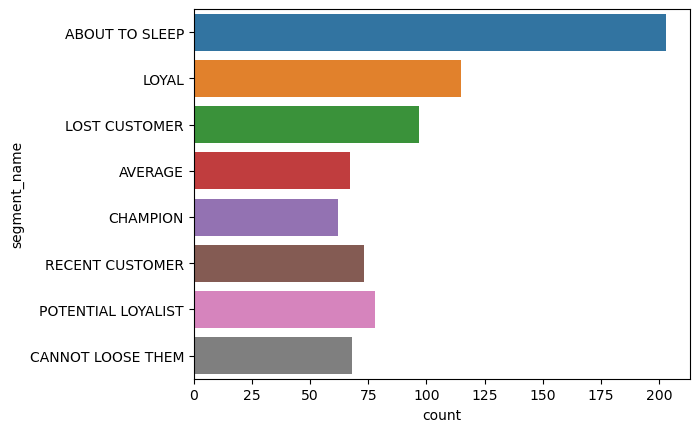

In [35]:
ax = sns.countplot(y="segment_name", data=rfm_segmentation)

2. Monetary

In [36]:
rfm_segmentation.groupby('segment_name')['Monetary'].sum()

segment_name
ABOUT TO SLEEP        173528.4159
AVERAGE               100712.8218
CANNOT LOOSE THEM     147542.9220
CHAMPION              183704.3298
LOST CUSTOMER          21914.8130
LOYAL                 251623.6699
POTENTIAL LOYALIST    128632.0583
RECENT CUSTOMER        57442.4430
Name: Monetary, dtype: float64

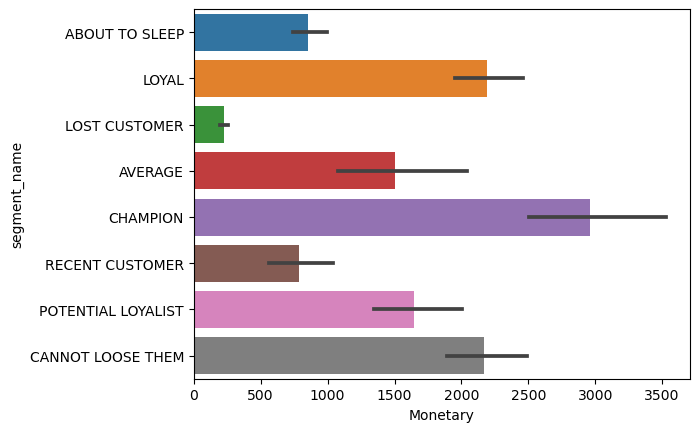

In [37]:
sns.barplot(x = "Monetary", y = "segment_name", data = rfm_segmentation)
plt.show()

*The line in the middle of the bar shows us how confident we are about the average amount of money spent by each group of customers. A short line means we're very sure, and a long line means we're not as sure.*

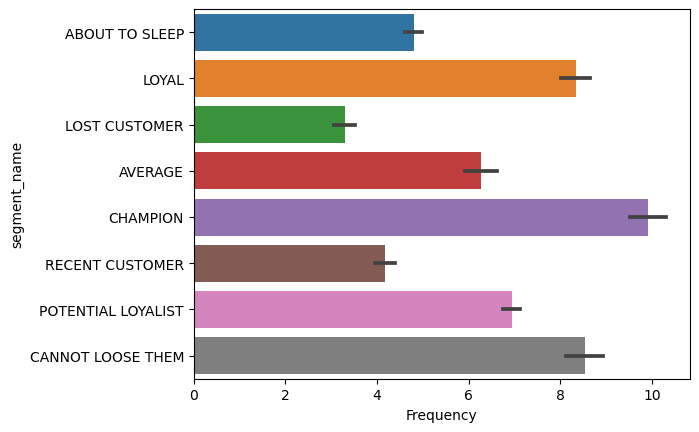

In [38]:
sns.barplot(x = "Frequency", y = "segment_name", data = rfm_segmentation)
plt.show()

3. Frequency

In [39]:
rfm_segmentation.groupby('segment_name')['Frequency'].sum()

segment_name
ABOUT TO SLEEP        975
AVERAGE               420
CANNOT LOOSE THEM     580
CHAMPION              614
LOST CUSTOMER         320
LOYAL                 960
POTENTIAL LOYALIST    542
RECENT CUSTOMER       305
Name: Frequency, dtype: int64

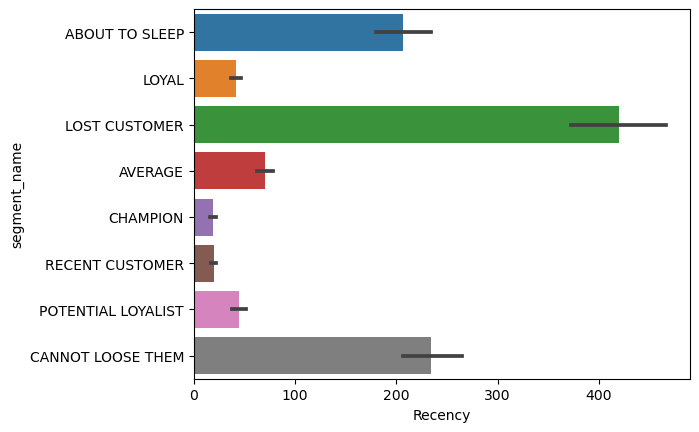

In [40]:
sns.barplot(x = "Recency", y = "segment_name", data = rfm_segmentation)
plt.show()

4. Recency

In [41]:
rfm_segmentation.groupby('segment_name')['Recency'].sum()

segment_name
ABOUT TO SLEEP        41886
AVERAGE                4694
CANNOT LOOSE THEM     15956
CHAMPION               1184
LOST CUSTOMER         40788
LOYAL                  4750
POTENTIAL LOYALIST     3456
RECENT CUSTOMER        1440
Name: Recency, dtype: int64

## Elbow method analysis

We utilize the elbow method to determine the optimal number of clusters for our dataset. The elbow method helps identify the point where adding more clusters does not significantly improve the model's performance, thus finding a balance between model complexity and effectiveness

  File "c:\Users\Syma\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


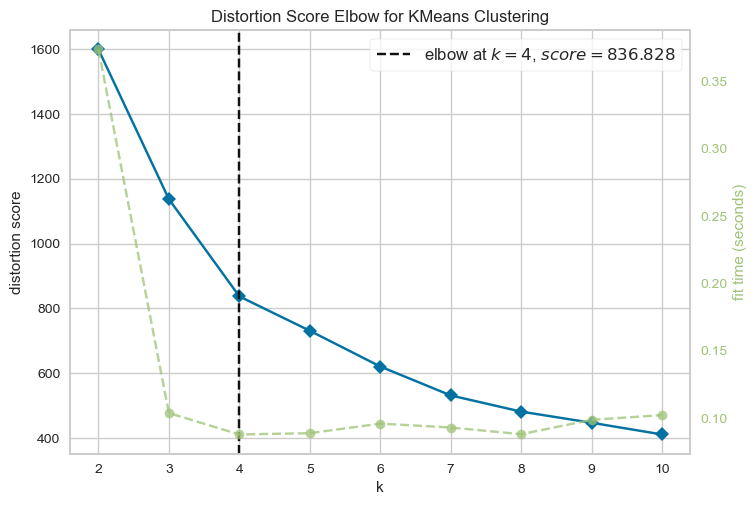

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [42]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
X = rfm_segmentation[['Recency', 'Frequency', 'Monetary']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Instantiate the KMeans model
kmeans = KMeans(random_state=42)

# Instantiate the KElbowVisualizer
visualizer = KElbowVisualizer(kmeans, k=(2, 11))

# Fit the visualizer to the data
visualizer.fit(X_scaled)

# Finalize and display the figure
visualizer.show()


After getting the optimal number of clusters **(k=4)** using the elbow method, we proceed to perform KMeans clustering on our dataset.

In [43]:
from sklearn.cluster import KMeans
import pandas as pd

# Assuming rfm_segmentation is the DataFrame containing RFM variables
# Select features for clustering
X = rfm_segmentation[['Recency', 'Frequency', 'Monetary']]

# Instantiate KMeans with K=4
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit KMeans to the data
kmeans.fit(X)

# Assign cluster labels to each data point
cluster_labels = kmeans.labels_

# Add cluster labels to the DataFrame
rfm_segmentation['Cluster'] = cluster_labels

# Display the first few rows of the DataFrame with cluster labels
print(rfm_segmentation.head())


             Recency  Frequency  Monetary  R_Tertile  F_Tertile  M_Tertile  \
Customer ID                                                                  
AA-10315         184          5  5008.480          1          1          3   
AA-10375          19          9   718.000          3          3          2   
AA-10480         259          4    76.502          1          1          1   
AA-10645          55          6  1064.158          2          2          2   
AB-10015         415          3   283.316          1          1          1   

            RFM_Score    segment_name  Cluster  
Customer ID                                     
AA-10315          113  ABOUT TO SLEEP        1  
AA-10375          332           LOYAL        0  
AA-10480          111   LOST CUSTOMER        0  
AA-10645          222         AVERAGE        0  
AB-10015          111   LOST CUSTOMER        0  


After performing KMeans clustering and assigning cluster labels to each data point, the next step is to visualize the characteristics of each cluster. Visualization aids in understanding the distribution of data points within each cluster and identifying patterns or differences across clusters. In this context, we aim to visualize the distribution of the RFM (Recency, Frequency, Monetary) variables for each cluster.


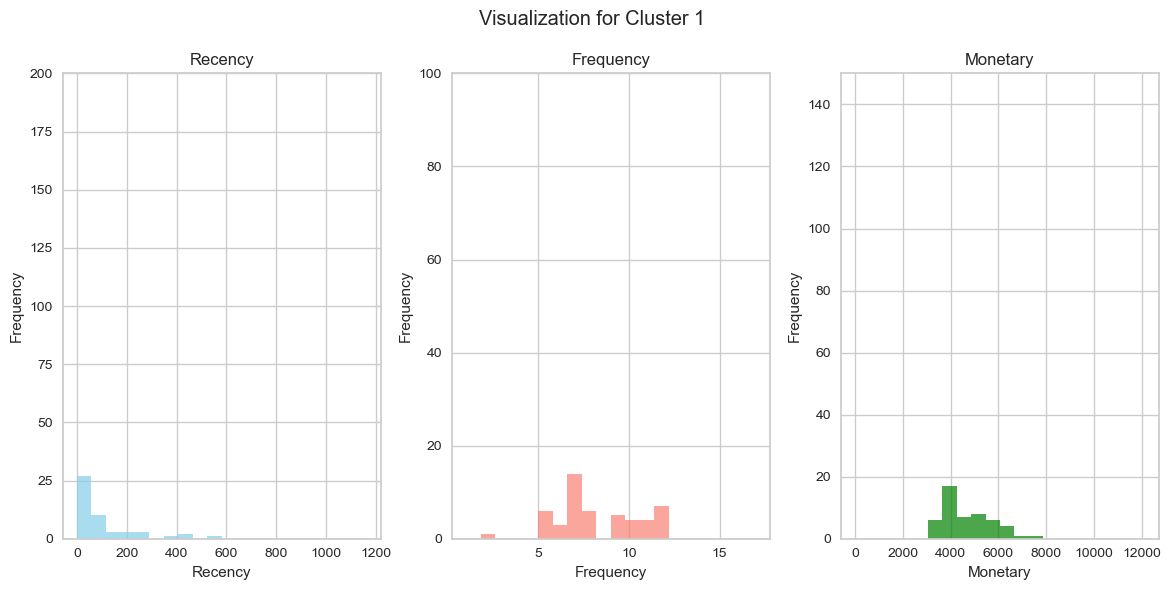

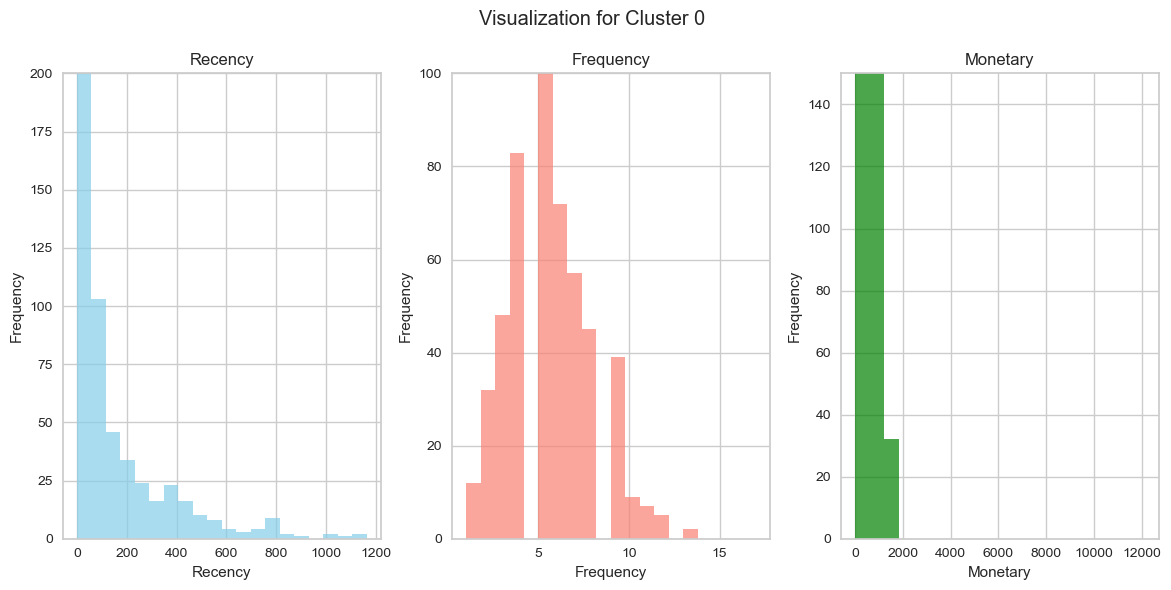

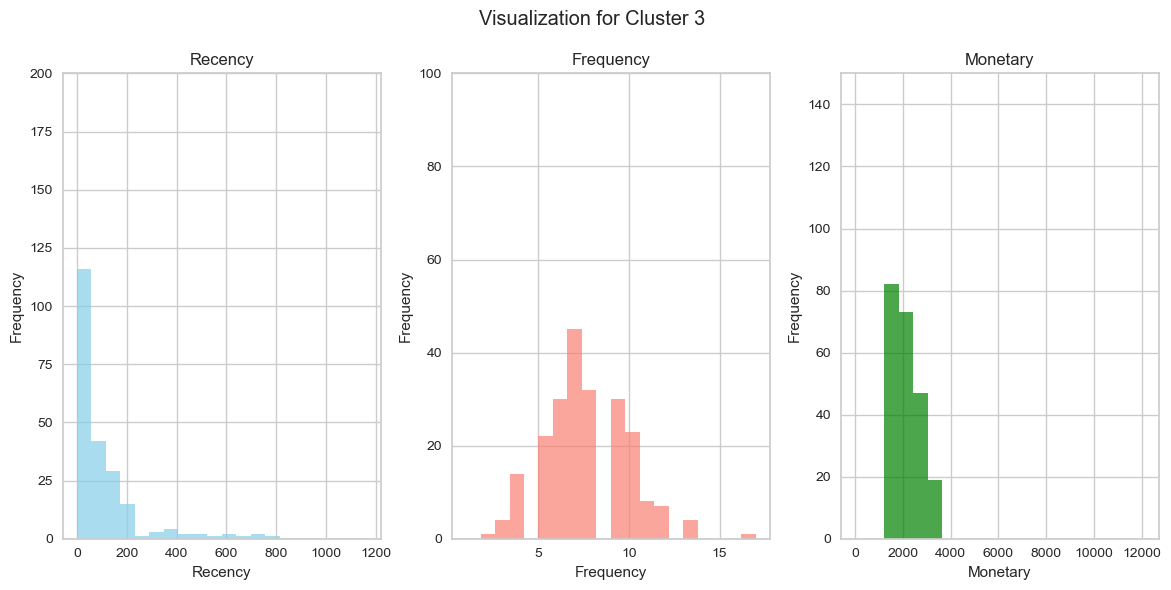

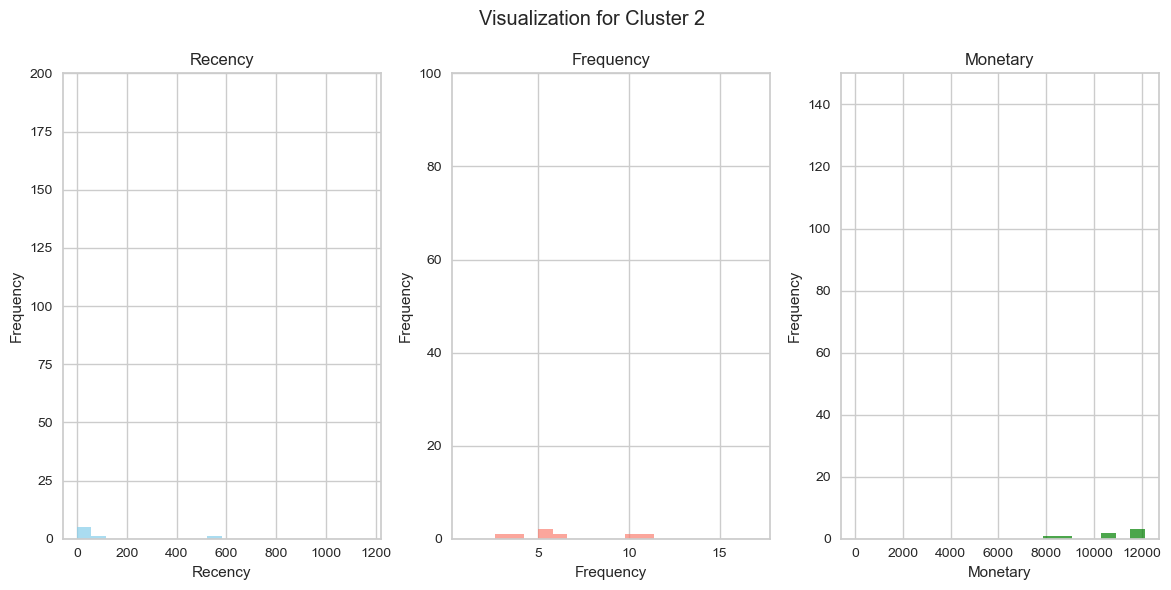

In [44]:
# Define maximum and minimum values for each feature
min_values = rfm_segmentation[['Recency', 'Frequency', 'Monetary']].min()
max_values = rfm_segmentation[['Recency', 'Frequency', 'Monetary']].max()

# Define maximum y-axis values for each feature
max_y_values = {'Recency': 200, 'Frequency': 100, 'Monetary': 150} 

# Visualize each cluster separately with standardized maximum y-axis values
for cluster in rfm_segmentation['Cluster'].unique():
    cluster_df = rfm_segmentation[rfm_segmentation['Cluster'] == cluster]
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Visualization for Cluster {cluster}')
    
    plt.subplot(1, 3, 1)
    plt.hist(cluster_df['Recency'], bins=20, color='skyblue', alpha=0.7, range=(min_values['Recency'], max_values['Recency']))
    plt.title('Recency')
    plt.xlabel('Recency')
    plt.ylabel('Frequency')
    plt.ylim(0, max_y_values['Recency'])  # Set maximum y-axis value
    
    plt.subplot(1, 3, 2)
    plt.hist(cluster_df['Frequency'], bins=20, color='salmon', alpha=0.7, range=(min_values['Frequency'], max_values['Frequency']))
    plt.title('Frequency')
    plt.xlabel('Frequency')
    plt.ylabel('Frequency')
    plt.ylim(0, max_y_values['Frequency'])  # Set maximum y-axis value
    
    plt.subplot(1, 3, 3)
    plt.hist(cluster_df['Monetary'], bins=20, color='green', alpha=0.7, range=(min_values['Monetary'], max_values['Monetary']))
    plt.title('Monetary')
    plt.xlabel('Monetary')
    plt.ylabel('Frequency')
    plt.ylim(0, max_y_values['Monetary'])  # Set maximum y-axis value
    
    plt.tight_layout()
    plt.show()



In [45]:
# Group the data by 'Cluster' and compute descriptive statistics for each cluster
cluster_describe = rfm_segmentation.groupby('Cluster').describe()

# Select only the desired rows (mean, std, min) from the descriptive statistics
selected_describe = cluster_describe.drop(['count', 'max'], axis=1, level=1)

# Transpose the DataFrame so that clusters become columns
cluster_describe_transposed = selected_describe.transpose()

# Print the transposed DataFrame
print("Descriptive Statistics for Each Cluster:")
print(cluster_describe_transposed)


Descriptive Statistics for Each Cluster:
Cluster                  0            1             2            3
Recency   mean  169.335922   102.700000    117.000000   105.095023
          std   204.607306   126.602745    195.319397   137.263731
          min     0.000000     2.000000      9.000000     0.000000
          25%    35.500000    21.250000     42.000000    28.000000
          50%    89.000000    47.000000     43.000000    54.000000
          75%   226.000000   115.750000     62.500000   120.000000
Frequency mean    5.566990     8.180000      6.285714     7.565611
          std     2.320790     2.404842      3.039424     2.304441
          min     1.000000     2.000000      3.000000     2.000000
          25%     4.000000     7.000000      4.500000     6.000000
          50%     5.000000     8.000000      5.000000     7.000000
          75%     7.000000    10.000000      8.000000     9.000000
Monetary  mean  613.245790  4676.545232  10514.649429  2134.402739
          std   385.3

### Descriptive Statistics Analysis for Each Cluster

#### Cluster 0:
- **Recency**: Customers in Cluster 0 have a relatively high mean recency of approximately 169 days, indicating that they made their last purchase quite some time ago. The standard deviation is high, suggesting variability in recency among customers in this cluster. The minimum recency value is 0, indicating some recent customers, while the maximum is 942 days.
- **Frequency**: The mean frequency of purchases for Cluster 0 is around 5.57, with a standard deviation of approximately 2.32. This cluster comprises customers who make fewer purchases compared to other clusters.
- **Monetary**: The mean monetary value for Cluster 0 is about 613.25, with considerable variability indicated by the standard deviation. This cluster represents customers with lower spending behavior compared to other clusters.

#### Cluster 1:
- **Recency**: Customers in Cluster 1 exhibit a lower mean recency of around 102.7 days, indicating more recent purchases compared to Cluster 0. The standard deviation is relatively high, suggesting variability in recency among customers in this cluster.
- **Frequency**: Cluster 1 has a higher mean frequency of approximately 8.18, indicating that customers in this cluster make more frequent purchases compared to Cluster 0.
- **Monetary**: The mean monetary value for Cluster 1 is significantly higher than Cluster 0, with a mean of about 4676.55. This suggests that customers in this cluster have higher spending behavior.


#### Cluster 2:
- **Recency**: Customers in Cluster 2 have a mean recency of approximately 117 days, with moderate variability indicated by the standard deviation. This cluster comprises customers with varied recency of purchases.
- **Frequency**: The mean frequency of purchases for Cluster 2 is around 6.29, indicating moderate purchase frequency among customers in this cluster.
- **Monetary**: Cluster 2 has the highest mean monetary value among all clusters, with a mean of about 10514.65. This suggests that customers in this cluster are high spenders.

#### Cluster 3:
- **Recency**: Customers in Cluster 3 have a mean recency of approximately 105.1 days, indicating relatively recent purchases compared to Cluster 0 but less recent compared to Clusters 1 and 2. The standard deviation is moderate, indicating some variability in recency among customers in this cluster.
- **Frequency**: Cluster 3 has a mean frequency of approximately 7.57, similar to Cluster 1 but lower than Cluster 2. This suggests moderate purchase frequency among customers in this cluster.
- **Monetary**: The mean monetary value for Cluster 3 is around 2134.40, indicating lower spending behavior compared to Clusters 1 and 2 but higher than Cluster 0.



Overall, these four clusters can be categorized as follows:

1. **Dormant/Low-Value Customers (Cluster 0)**: This cluster comprises customers with relatively high recency, indicating that they made their last purchase quite some time ago. They also exhibit lower purchase frequency and monetary value compared to other clusters, suggesting that they are less engaged or inactive customers.

2. **Active/High-Spending Customers (Cluster 1)**: Customers in this cluster have made relatively recent purchases and exhibit high purchase frequency and monetary value. They are likely loyal and engaged customers who make frequent purchases and contribute significantly to revenue.

3. **High-Value Customers (Cluster 2)**: Cluster 2 represents customers with the highest monetary value among all clusters. These customers make purchases with moderate frequency and have made relatively recent purchases, indicating that they are valuable and engaged customers with high spending behavior.

4. **Moderate-Value Customers (Cluster 3)**: Customers in this cluster have made purchases relatively recently but exhibit lower monetary value compared to Clusters 1 and 2. They make purchases with moderate frequency and represent a balance between spending and engagement compared to other clusters.

In [46]:
from sklearn.metrics import davies_bouldin_score

# Assuming X contains your feature matrix and cluster_labels contains the cluster labels assigned by K-means
db_index = davies_bouldin_score(X, cluster_labels)

print("Davies-Bouldin Index:", db_index)


Davies-Bouldin Index: 0.5098177798905217



The Davies-Bouldin Index (DBI) is a metric which measures the average similarity between each cluster and its most similar cluster while also considering their respective sizes. A lower DBI indicates better clustering, with values closer to zero suggesting well-separated clusters.

A DBI of approximately 0.51 suggests that the clusters generated by the KMeans algorithm are relatively well-separated and distinct. This means that the clustering algorithm has effectively grouped data points into clusters where data points within each cluster are similar to each other and dissimilar to data points in other clusters.

## Calinski-Harabasz Method
In this section, I employed the Calinski-Harabasz method to determine the optimal number of clusters for the dataset. This method, also known as the Variance Ratio Criterion, measures the ratio of between-cluster dispersion to within-cluster dispersion. The goal is to find the number of clusters that maximizes this ratio, indicating dense and well-separated clusters.

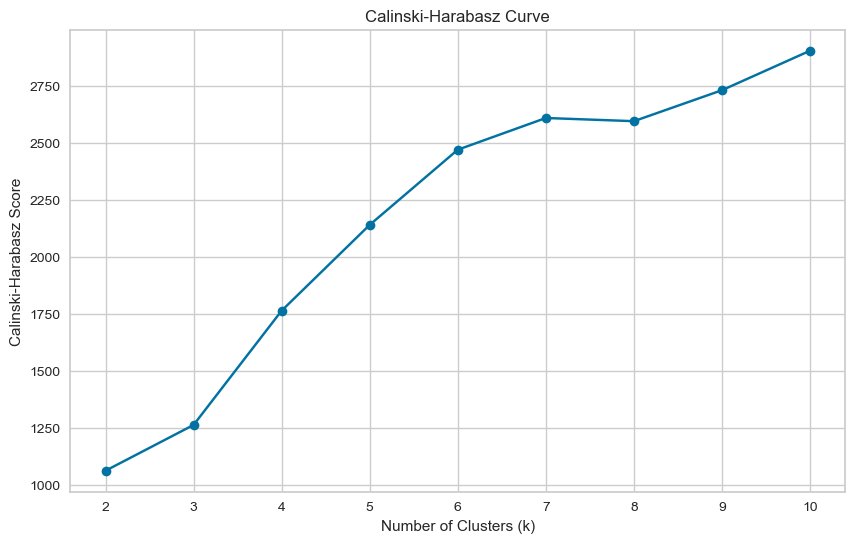

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming rfm_segmentation is the DataFrame containing RFM variables
# Let's select the RFM variables for clustering
X = rfm_segmentation[['Recency', 'Frequency', 'Monetary']]

# Initialize an empty list to store Calinski-Harabasz scores
ch_scores = []

# Define a range of cluster numbers to test
k_values = range(2, 11)

# Iterate over each cluster number
for k in k_values:
    # Fit KMeans clustering with the current number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    
    # Compute Calinski-Harabasz score and append to the list
    ch_score = calinski_harabasz_score(X, kmeans.labels_)
    ch_scores.append(ch_score)

# Plot the Calinski-Harabasz curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, ch_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Curve')
plt.xticks(np.arange(min(k_values), max(k_values)+1, 1.0))
plt.grid(True)
plt.show()


The Calinski-Harabasz curve initially increased up to 7 clusters, indicating improved clustering quality. However, it dropped at 8 clusters, suggesting decreased quality, before rising again with additional clusters. I chose 7 clusters based on this trend, aiming for a balance between clustering quality and interpretability.

In [48]:
from sklearn.cluster import KMeans
import pandas as pd

# Assuming rfm_segmentation is the DataFrame containing RFM variables
# Select features for clustering
X = rfm_segmentation[['Recency', 'Frequency', 'Monetary']]

# Instantiate KMeans with K=7
kmeans = KMeans(n_clusters=7, random_state=42)

# Fit KMeans to the data
kmeans.fit(X)

# Assign cluster labels to each data point
cluster_labels = kmeans.labels_

# Add cluster labels to the DataFrame
rfm_segmentation['Cluster'] = cluster_labels

# Display the first few rows of the DataFrame with cluster labels
print(rfm_segmentation.head())


             Recency  Frequency  Monetary  R_Tertile  F_Tertile  M_Tertile  \
Customer ID                                                                  
AA-10315         184          5  5008.480          1          1          3   
AA-10375          19          9   718.000          3          3          2   
AA-10480         259          4    76.502          1          1          1   
AA-10645          55          6  1064.158          2          2          2   
AB-10015         415          3   283.316          1          1          1   

            RFM_Score    segment_name  Cluster  
Customer ID                                     
AA-10315          113  ABOUT TO SLEEP        1  
AA-10375          332           LOYAL        0  
AA-10480          111   LOST CUSTOMER        4  
AA-10645          222         AVERAGE        0  
AB-10015          111   LOST CUSTOMER        4  


Same thing here, the next step is to visualize the characteristics of each cluster. Visualization aids in understanding the distribution of data points within each cluster and identifying patterns or differences across clusters.

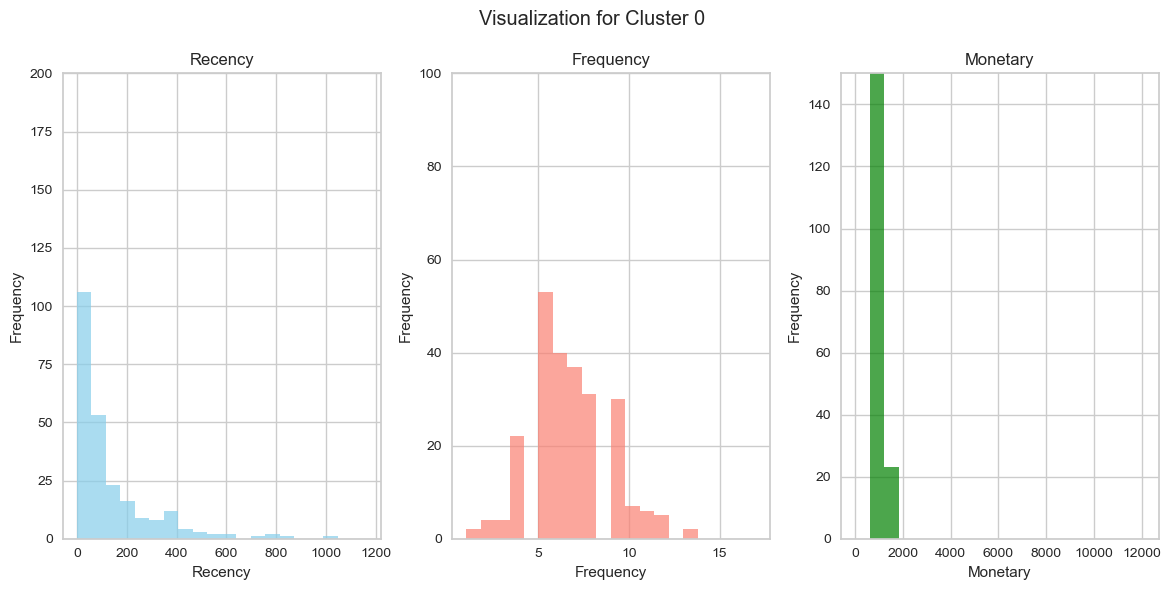

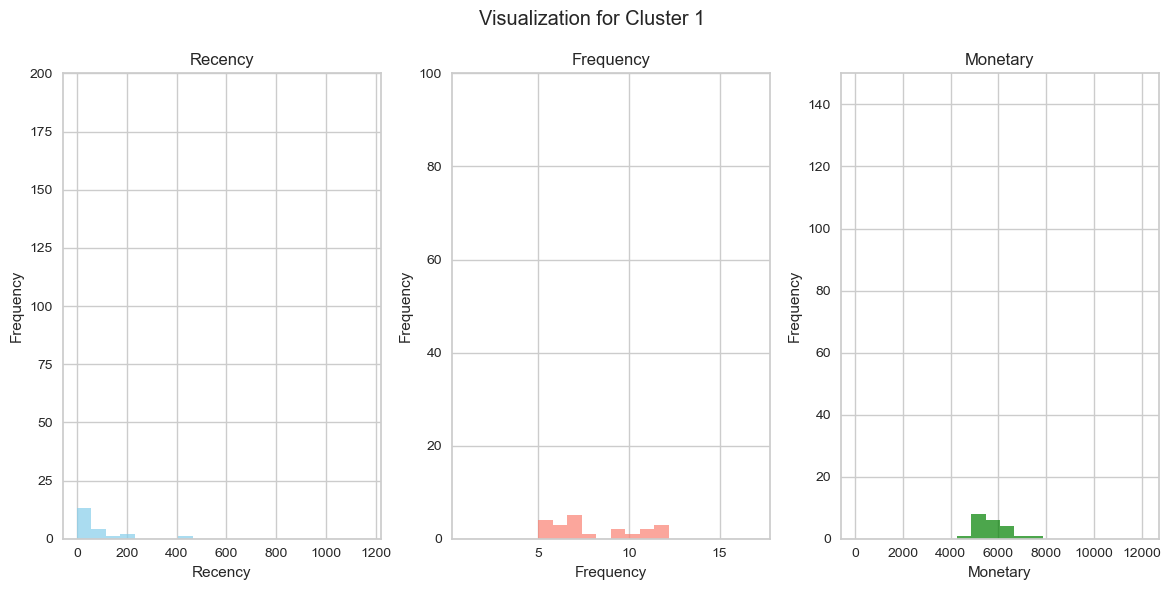

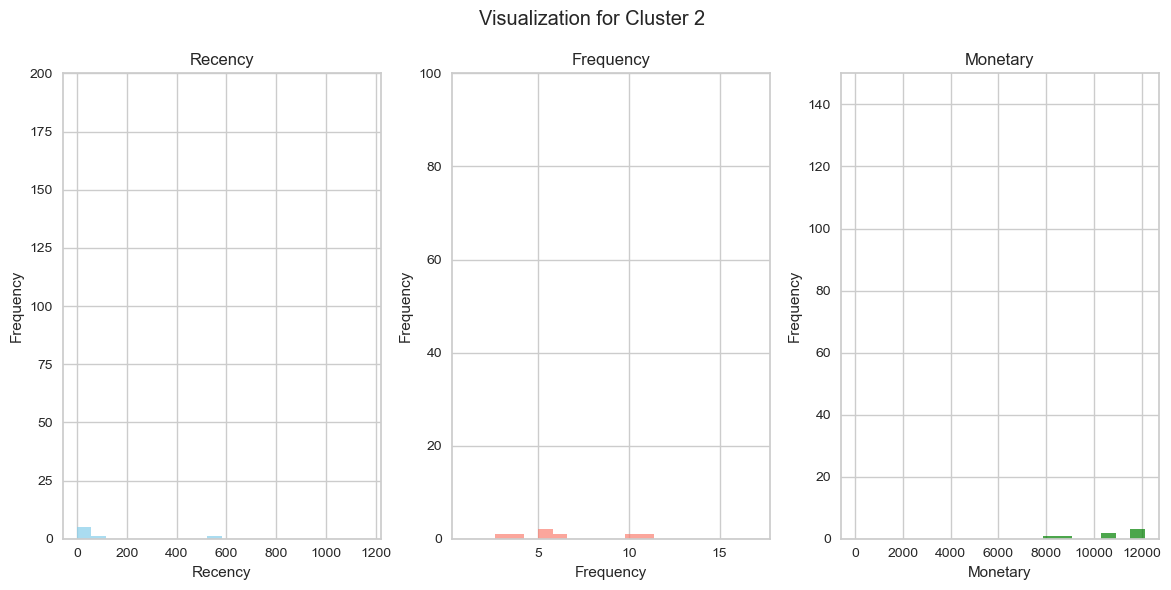

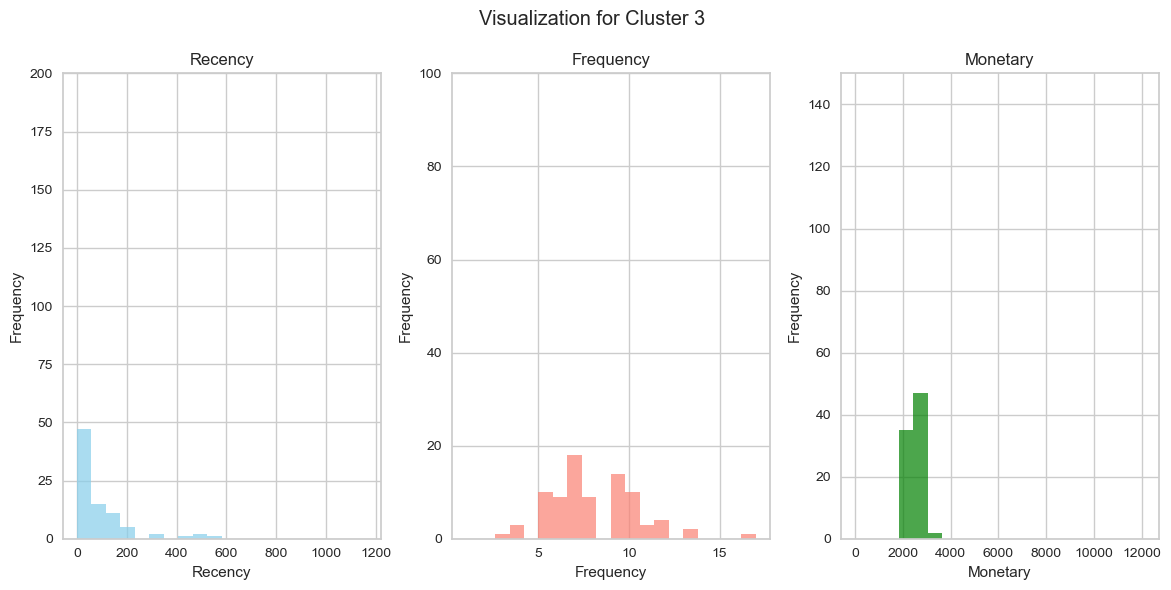

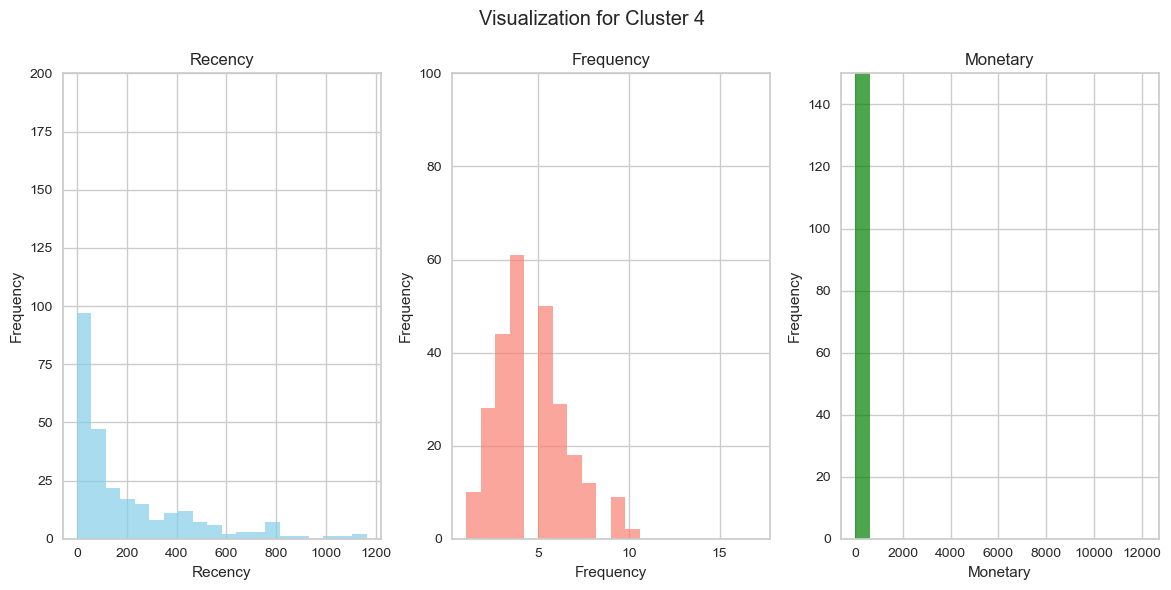

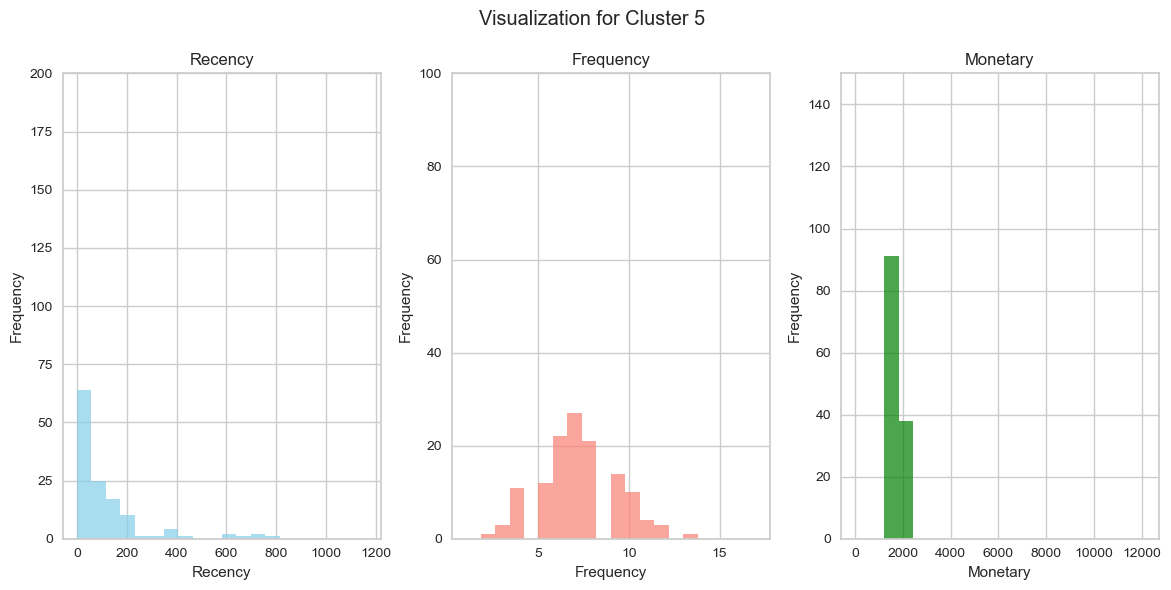

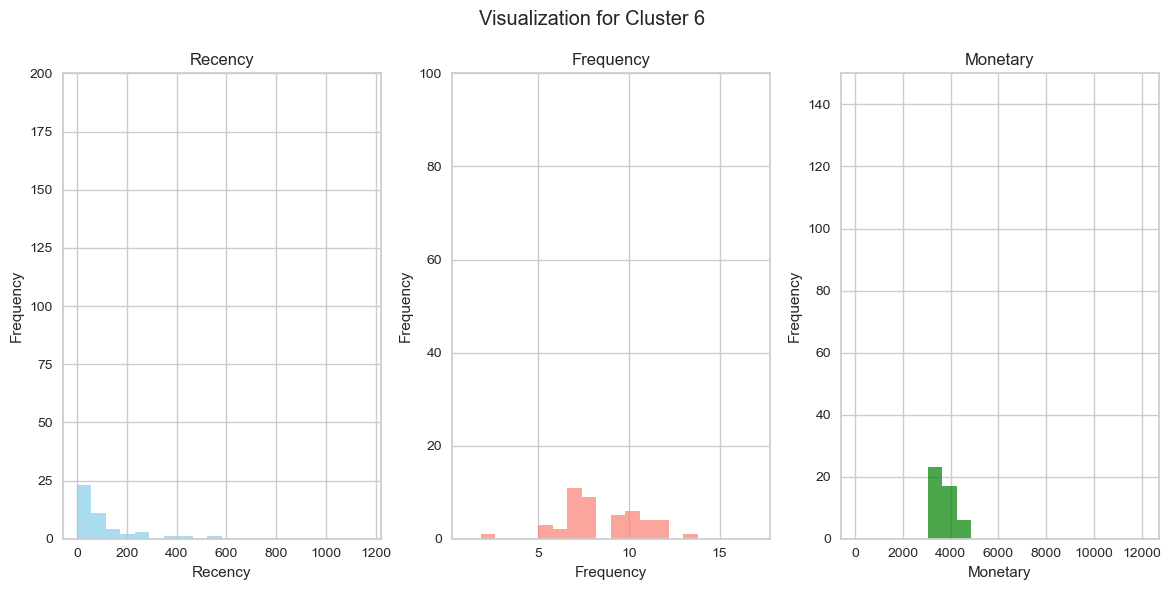

In [49]:
import matplotlib.pyplot as plt

# Define maximum and minimum values for each feature
min_values = rfm_segmentation[['Recency', 'Frequency', 'Monetary']].min()
max_values = rfm_segmentation[['Recency', 'Frequency', 'Monetary']].max()

# Define maximum y-axis values for each feature
max_y_values = {'Recency': 200, 'Frequency': 100, 'Monetary': 150}  # Adjusted to match the features in the current workbook

# Visualize each cluster separately with standardized maximum y-axis values
for cluster in range(7):  # Iterate over 7 clusters
    cluster_df = rfm_segmentation[rfm_segmentation['Cluster'] == cluster]
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Visualization for Cluster {cluster}')
    
    plt.subplot(1, 3, 1)
    plt.hist(cluster_df['Recency'], bins=20, color='skyblue', alpha=0.7, range=(min_values['Recency'], max_values['Recency']))
    plt.title('Recency')
    plt.xlabel('Recency')
    plt.ylabel('Frequency')
    plt.ylim(0, max_y_values['Recency'])  # Set maximum y-axis value
    
    plt.subplot(1, 3, 2)
    plt.hist(cluster_df['Frequency'], bins=20, color='salmon', alpha=0.7, range=(min_values['Frequency'], max_values['Frequency']))
    plt.title('Frequency')
    plt.xlabel('Frequency')
    plt.ylabel('Frequency')
    plt.ylim(0, max_y_values['Frequency'])  # Set maximum y-axis value
    
    plt.subplot(1, 3, 3)
    plt.hist(cluster_df['Monetary'], bins=20, color='green', alpha=0.7, range=(min_values['Monetary'], max_values['Monetary']))
    plt.title('Monetary')
    plt.xlabel('Monetary')
    plt.ylabel('Frequency')
    plt.ylim(0, max_y_values['Monetary'])  # Set maximum y-axis value
    
    plt.tight_layout()
    plt.show()


In [50]:
# Group the data by 'Cluster' and compute descriptive statistics for each cluster
cluster_describe = rfm_segmentation.groupby('Cluster').describe()

# Select only the desired rows (mean, std, min) from the descriptive statistics
selected_describe = cluster_describe.drop(['count', 'max'], axis=1, level=1)

# Transpose the DataFrame so that clusters become columns
cluster_describe_transposed = selected_describe.transpose()

# Print the transposed DataFrame
print("Descriptive Statistics for Each Cluster:")
print(cluster_describe_transposed)



Descriptive Statistics for Each Cluster:
Cluster                   0            1             2            3  \
Recency   mean   138.176955    75.619048    117.000000    92.166667   
          std    166.654929    98.480697    195.319397   113.279251   
          min      1.000000     4.000000      9.000000     1.000000   
          25%     31.000000    11.000000     42.000000    25.750000   
          50%     75.000000    29.000000     43.000000    53.500000   
          75%    176.000000   109.000000     62.500000   117.000000   
Frequency mean     6.641975     7.952381      6.285714     7.940476   
          std      2.191128     2.499524      3.039424     2.436426   
          min      1.000000     5.000000      3.000000     3.000000   
          25%      5.000000     6.000000      4.500000     6.000000   
          50%      6.000000     7.000000      5.000000     8.000000   
          75%      8.000000    10.000000      8.000000     9.000000   
Monetary  mean   940.627462  5678.57

### Descriptive Statistics for Each Cluster

#### Cluster 0:
- **Recency**: Customers in this cluster have a mean recency of approximately 138 days, with a standard deviation of 166 days. The range of recency varies widely, from 1 day to 176 days.
- **Frequency**: The average frequency of purchases is around 6.64, with a standard deviation of 2.19. Customers in this cluster make purchases ranging from 1 to 8 times.
- **Monetary**: The mean monetary value is about 941, with a standard deviation of 199. Customers in this cluster spend between 617 and 1116 monetary units.

#### Cluster 1:
- **Recency**: Customers in this cluster have a mean recency of approximately 76 days, with a standard deviation of 98 days. The range of recency varies from 4 to 109 days.
- **Frequency**: The average frequency of purchases is around 7.95, with a standard deviation of 2.50. Customers in this cluster make purchases ranging from 5 to 10 times.
- **Monetary**: The mean monetary value is about 5679, with a standard deviation of 642. Customers in this cluster spend between 4791 and 6125 monetary units.

#### Cluster 2:
- **Recency**: Customers in this cluster have a mean recency of approximately 117 days, with a standard deviation of 195 days. The range of recency varies from 9 to 62 days.
- **Frequency**: The average frequency of purchases is around 6.29, with a standard deviation of 3.04. Customers in this cluster make purchases ranging from 3 to 8 times.
- **Monetary**: The mean monetary value is about 10515, with a standard deviation of 1487. Customers in this cluster spend between 8175 and 11682 monetary units.

#### Cluster 3:
- **Recency**: Customers in this cluster have a mean recency of approximately 92 days, with a standard deviation of 113 days. The range of recency varies from 1 to 117 days.
- **Frequency**: The average frequency of purchases is around 7.94, with a standard deviation of 2.44. Customers in this cluster make purchases ranging from 3 to 9 times.
- **Monetary**: The mean monetary value is about 2518, with a standard deviation of 274. Customers in this cluster spend between 2111 and 2763 monetary units.

#### Cluster 4:
- **Recency**: Customers in this cluster have a mean recency of approximately 202 days, with a standard deviation of 232 days. The range of recency varies from 0 to 287 days.
- **Frequency**: The average frequency of purchases is around 4.52, with a standard deviation of 1.95. Customers in this cluster make purchases ranging from 1 to 6 times.
- **Monetary**: The mean monetary value is about 286, with a standard deviation of 170. Customers in this cluster spend between 5 and 411 monetary units.

#### Cluster 5:
- **Recency**: Customers in this cluster have a mean recency of approximately 116 days, with a standard deviation of 154 days. The range of recency varies from 0 to 135 days.
- **Frequency**: The average frequency of purchases is around 7.16, with a standard deviation of 2.13. Customers in this cluster make purchases ranging from 2 to 8 times.
- **Monetary**: The mean monetary value is about 1680, with a standard deviation of 222. Customers in this cluster spend between 1321 and 1853 monetary units.

#### Cluster 6:
- **Recency**: Customers in this cluster have a mean recency of approximately 101 days, with a standard deviation of 120 days. The range of recency varies from 1 to 114 days.
- **Frequency**: The average frequency of purchases is around 8.43, with a standard deviation of 2.25. Customers in this cluster make purchases ranging from 2 to 10 times.
- **Monetary**: The mean monetary value is about 3699, with a standard deviation of 427. Customers in this cluster spend between 3141 and 3988 monetary units.


### Overall Categorization of Clusters:

#### Cluster 0:
- **Category**: Infrequent and Low-Spending Customers
- **Description**: Customers in this cluster have relatively high recency, low frequency, and low monetary value. They are infrequent shoppers who spend less compared to other clusters.

#### Cluster 1:
- **Category**: High-Frequency, High-Spending Customers
- **Description**: Customers in this cluster have low recency, high frequency, and high monetary value. They are frequent shoppers who contribute significantly to revenue.

#### Cluster 2:
- **Category**: Recent, Moderate-Spending Customers
- **Description**: Customers in this cluster have moderate recency, frequency, and monetary value. They are relatively recent shoppers with moderate spending habits.

#### Cluster 3:
- **Category**: Moderate Recency, Moderate-Spending Customers
- **Description**: Customers in this cluster have moderate recency, frequency, and monetary value. They are neither the most recent nor the highest spenders, but they contribute consistently.

#### Cluster 4:
- **Category**: Infrequent, Low-Spending Customers
- **Description**: Customers in this cluster have high recency, low frequency, and low monetary value. They are infrequent shoppers who spend less compared to other clusters.

#### Cluster 5:
- **Category**: Recent, Moderate-Spending Customers
- **Description**: Customers in this cluster have relatively low recency, moderate frequency, and moderate monetary value. They are recent shoppers with moderate spending habits.

#### Cluster 6:
- **Category**: High-Frequency, High-Spending Customers
- **Description**: Customers in this cluster have low recency, high frequency, and high monetary value. They are frequent shoppers who contribute significantly to revenue.


In [51]:
from sklearn.metrics import davies_bouldin_score

# Assuming X contains your feature matrix and cluster_labels contains the cluster labels assigned by K-means
db_index = davies_bouldin_score(X, cluster_labels)

print("Davies-Bouldin Index:", db_index)


Davies-Bouldin Index: 0.5790096932368657


### Davies-Bouldin Index Analysis:

The Davies-Bouldin Index is a metric used to evaluate the clustering quality, where lower values indicate better clustering. In this case, the Davies-Bouldin Index obtained from the Calinski curve method is approximately 0.579.

Comparison with Elbow Method:
- The Davies-Bouldin Index obtained from the Calinski curve is higher than the one obtained from the elbow method, which was approximately 0.51.
- The elbow method suggested the optimal number of clusters as 4, whereas the Calinski curve indicated fluctuations around this point, with the curve increasing until 7 clusters and then dropping at 8 before increasing again.
- This difference suggests some level of inconsistency between the two methods in determining the optimal number of clusters.

Interpretation:
- A Davies-Bouldin Index value of 0.579 indicates relatively good cluster separation but with some overlap and ambiguity.
- The fluctuations observed in the Calinski curve might signify that the data may not exhibit clear separation into distinct clusters.
- While the elbow method provided a clearer recommendation, the Calinski curve's behavior suggests potential uncertainty or complexity in the data structure.
